In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
)
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

```

1. Importa las librerías necesarias para entrenar modelos de regresión logística con
validación cruzada y Extreme Gradient Boosting, carga los datos y prepáralos. Para
ello:
a. elimina la columna ‘Unnamed: 0’.
b. codifica la variable objetivo Category en dos categorías: una para
Category=’0=Blood Donor’, a la que debes asociar valor 0, y un 1 para los
demás valores. Asigna estos valores en una nueva columna llamada target.
c. codifica en otra columna, con nombre suspect, con valor 1 cuando
Category=’0s=suspect Blood Donor’, y aigna 0 en caso contrario. Elimina
finalmente la columna Category.
d. Revisa si la base de datos contiene valores ausentes. En caso que sea así,
aplica los siguientes criterios:
i. si el porcentaje de valores ausentes para alguna variable es menor a
1%, entonces elimina las filas que contengan estos valores ausentes
ii. si el porcentaje de valores ausentes es mayor, entonces reemplaza
estos por el promedio según la clase a la que pertenezca el valor
ausente.
e. Realiza un análisis descriptivo para cada variable regresora, usando gráficos
para representar distribuciones y boxplot para revisar posibles outliers.
Construye un heatmap que muestre las correlaciones entre las variables
regresoras y describe.
f. Transforma las variables regresoras por medio de la estandarización.
Muestra el antes y después de esta usando boxplots, y realiza una
segmentación de la muestra en 33% para test y el resto para entrenamien
```

In [2]:
# Cargar los datos
df = pd.read_csv("blood_donation.csv")
df

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,3=Cirrhosis,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,612,3=Cirrhosis,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
612,613,3=Cirrhosis,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
613,614,3=Cirrhosis,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


```a. elimina la columna ‘Unnamed: 0’.```

In [3]:
# Eliminar la columna 'Unnamed: 0'
df.drop(columns=["Unnamed: 0"], inplace=True)

In [4]:
df['Category']

0      0=Blood Donor
1      0=Blood Donor
2      0=Blood Donor
3      0=Blood Donor
4      0=Blood Donor
           ...      
610      3=Cirrhosis
611      3=Cirrhosis
612      3=Cirrhosis
613      3=Cirrhosis
614      3=Cirrhosis
Name: Category, Length: 615, dtype: object

```
b. codifica la variable objetivo Category en dos categorías: una para
Category=’0=Blood Donor’, a la que debes asociar valor 0, y un 1 para los
demás valores. Asigna estos valores en una nueva columna llamada target.
c. codifica en otra columna, con nombre suspect, con valor 1 cuando
Category=’0s=suspect Blood Donor’, y aigna 0 en caso contrario. Elimina
finalmente la columna Category
```

In [5]:
# Codificar la variable objetivo 'Category'
df["target"] = df["Category"].apply(lambda x: 0 if x == "0=Blood Donor" else 1)

# Codificar la columna 'suspect'
df["suspect"] = df["Category"].apply(
    lambda x: 1 if x == "0s=suspect Blood Donor" else 0
)
df

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,target,suspect
0,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0,0
1,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0,0
2,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0,0
3,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0,0
4,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,3=Cirrhosis,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,1,0
611,3=Cirrhosis,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,1,0
612,3=Cirrhosis,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,1,0
613,3=Cirrhosis,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,1,0


In [6]:
# Eliminar la columna 'Category'
df.drop(columns=["Category"], inplace=True)
df

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,target,suspect
0,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0,0
1,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0,0
2,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0,0
3,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0,0
4,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,1,0
611,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,1,0
612,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,1,0
613,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,1,0


``` 
d. Revisa si la base de datos contiene valores ausentes. En caso que sea así,
aplica los siguientes criterios:
i. si el porcentaje de valores ausentes para alguna variable es menor a
1%, entonces elimina las filas que contengan estos valores ausentes
ii. si el porcentaje de valores ausentes es mayor, entonces reemplaza
estos por el promedio según la clase a la que pertenezca el valor
ausente. 

In [7]:
# Codificar la columna 'Sex'
df = pd.get_dummies(df, columns=["Sex"], drop_first=True)

In [8]:
# Verificar valores ausentes
missing_data = df.isnull().mean() * 100
print(missing_data)


Age        0.000000
ALB        0.162602
ALP        2.926829
ALT        0.162602
AST        0.000000
BIL        0.000000
CHE        0.000000
CHOL       1.626016
CREA       0.000000
GGT        0.000000
PROT       0.162602
target     0.000000
suspect    0.000000
Sex_m      0.000000
dtype: float64


In [9]:
# Manejo de valores ausentes
# Eliminar filas con menos del 1% de valores ausentes
df = df.dropna(subset=["ALB", "ALT", "PROT"])

# Reemplazar valores ausentes con el promedio por clase para variables con más del 1%
for col in ["ALP", "CHOL"]:
    df[col] = df.groupby("target")[col].transform(lambda x: x.fillna(x.mean()))

# Verificar que no queden valores ausentes
print(df.isnull().sum())

Age        0
ALB        0
ALP        0
ALT        0
AST        0
BIL        0
CHE        0
CHOL       0
CREA       0
GGT        0
PROT       0
target     0
suspect    0
Sex_m      0
dtype: int64


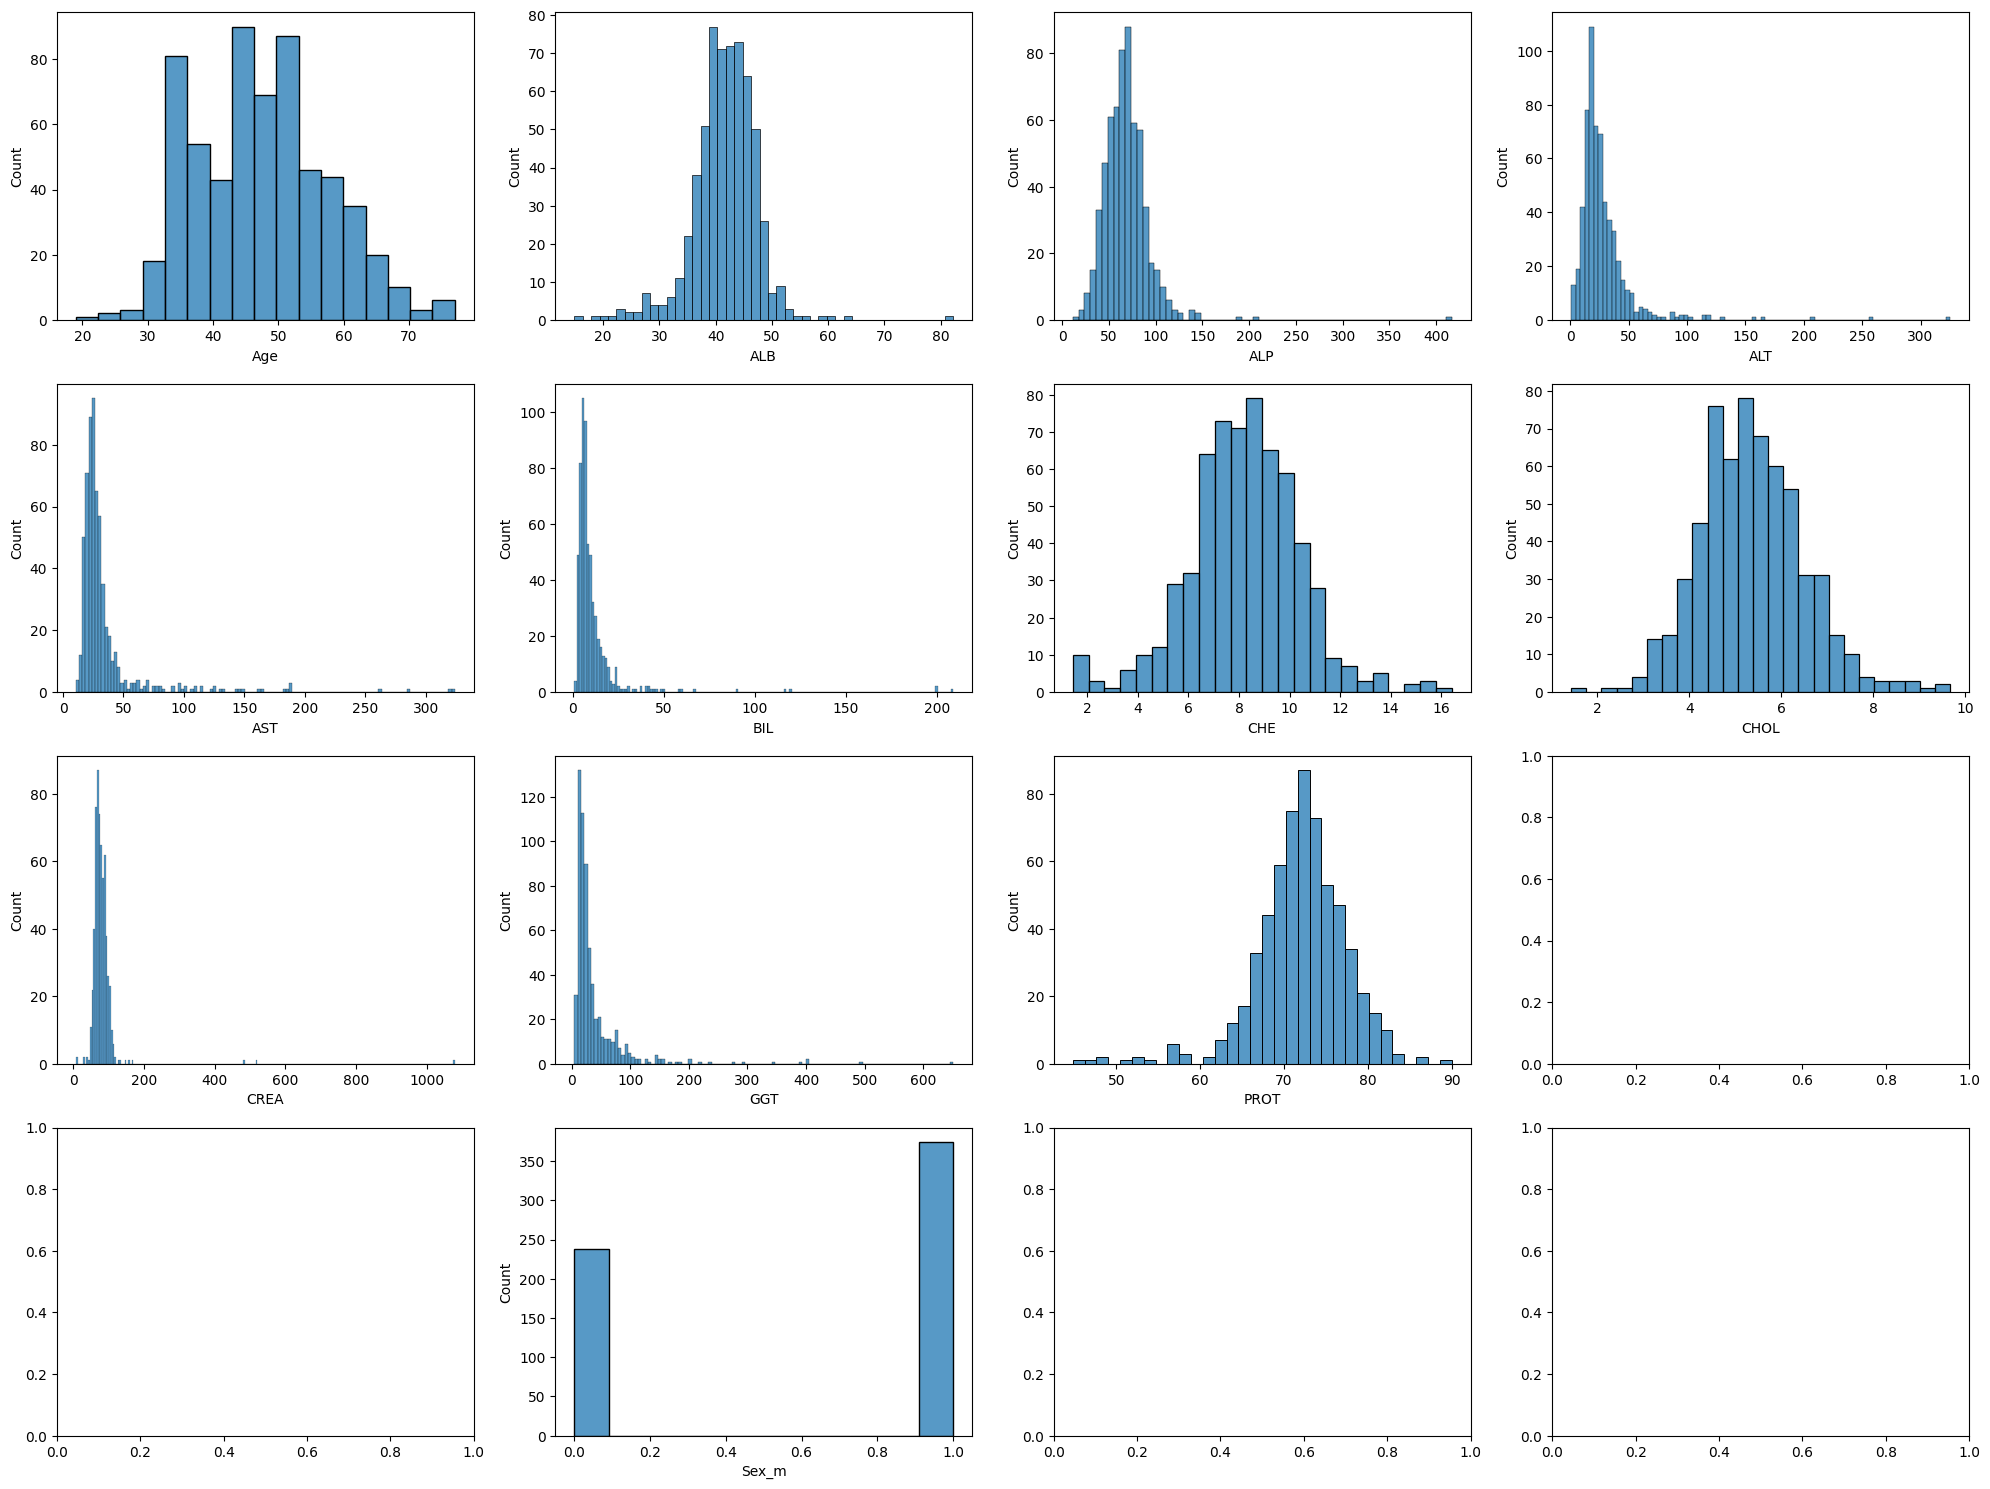

In [10]:
# Análisis descriptivo y visualización
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    if col not in ["target", "suspect"]:
        sns.histplot(df[col], ax=axes[i])
plt.tight_layout()
plt.show()

``` 
e. Realiza un análisis descriptivo para cada variable regresora, usando gráficos
para representar distribuciones y boxplot para revisar posibles outliers.
Construye un heatmap que muestre las correlaciones entre las variables
regresoras y describe.

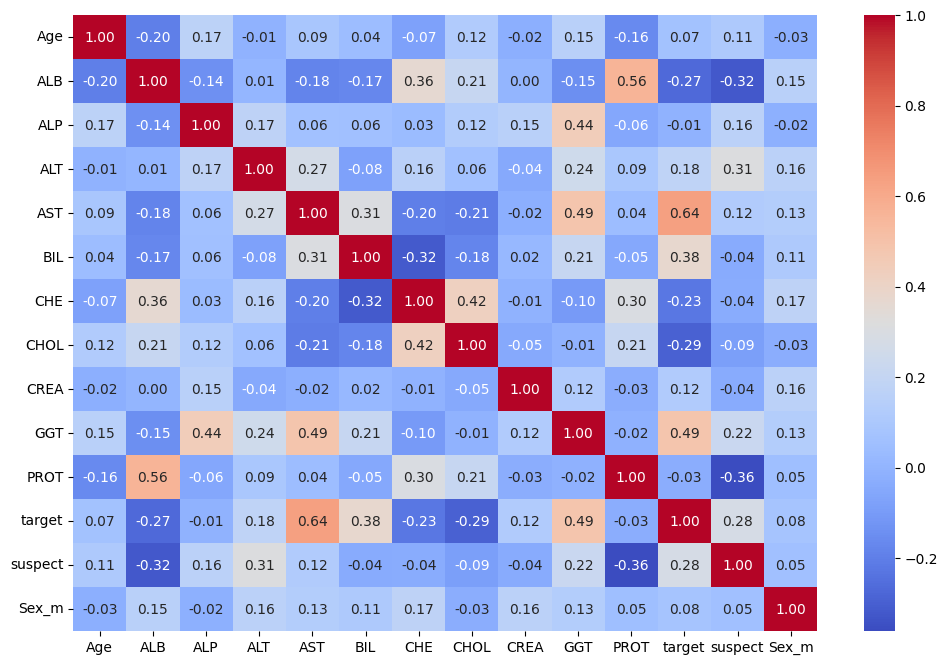

In [11]:
# Heatmap de correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

``` 
f. Transforma las variables regresoras por medio de la estandarización.
Muestra el antes y después de esta usando boxplots, y realiza una
segmentación de la muestra en 33% para test y el resto para entrenamien

In [12]:
# Estandarización de las variables regresoras
features = df.drop(columns=["target", "suspect"])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

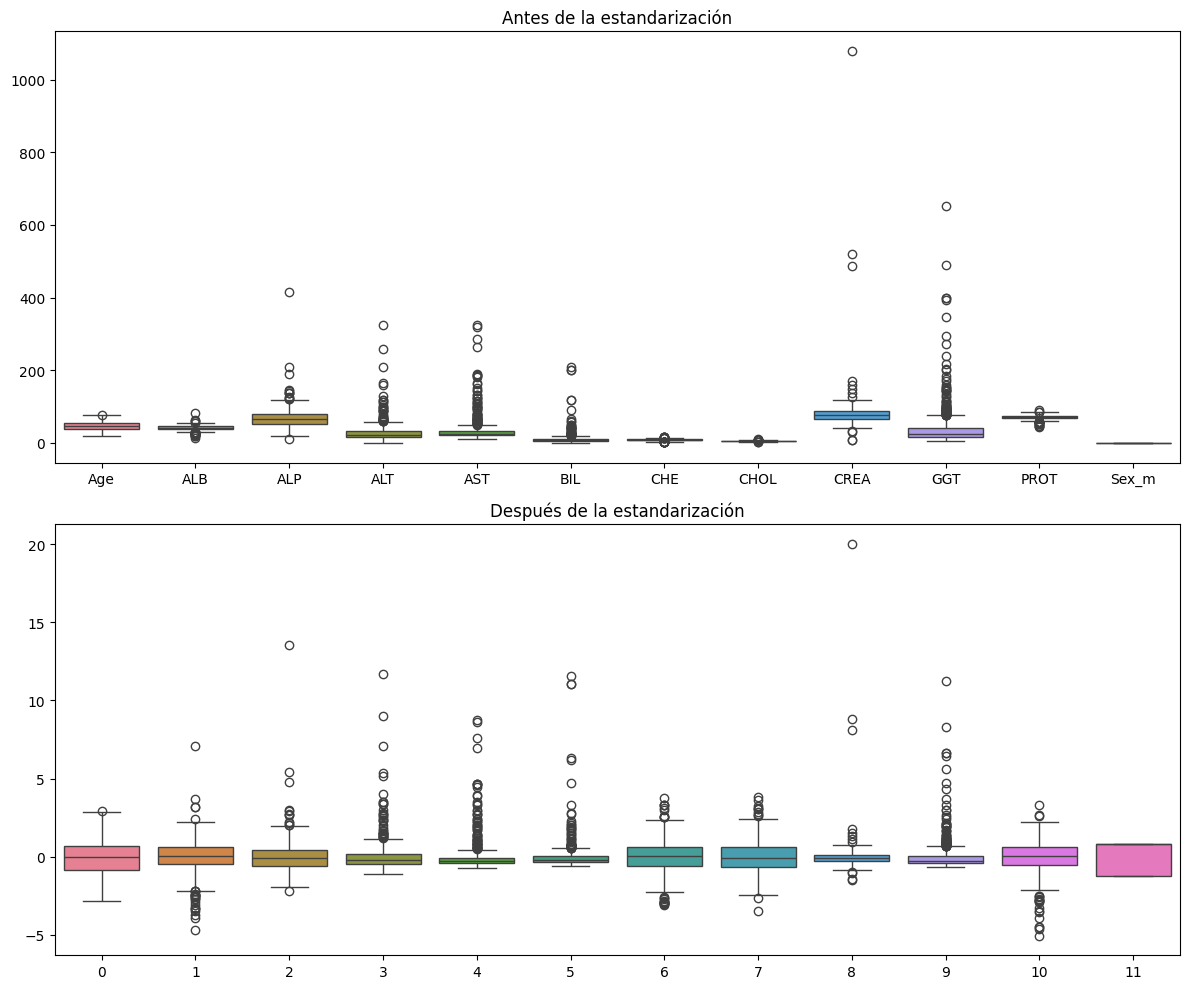

In [13]:
# Mostrar el antes y después de la estandarización
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.boxplot(data=features, ax=axes[0])
axes[0].set_title("Antes de la estandarización")
sns.boxplot(data=features_scaled, ax=axes[1])
axes[1].set_title("Después de la estandarización")
plt.tight_layout()
plt.show()

In [14]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, df["target"], test_size=0.33, random_state=42
)

print("Datos preparados y divididos correctamente.")

Datos preparados y divididos correctamente.


```
2. Desarrolla un modelo regresión logística con validación cruzada usando 5-fold, con
regularización Elastic Net. Busca para los siguientes hiper parámetros:
● Cs: valores entre 0.01 y 5.0, con 200 valores lineales.
● l1_ratio: valores entre 0 y 1, con 200 valores lineales.
Muestra los valores óptimos encontrados, y las métricas precisión, recall, f1-score y
accuracy. Describe cuáles son las tres características con mayor incidencia en la
predicción de sujeto o muestra con sangre con posible enfermedad.


In [15]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Hiperparámetros para la búsqueda
Cs = np.linspace(0.01, 5.0, 200)
l1_ratios = np.linspace(0, 1, 200)

# Crear el modelo de regresión logística con validación cruzada
logreg_cv = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=l1_ratios,
    scoring="accuracy",
    max_iter=10000,
)

# Ajustar el modelo
logreg_cv.fit(X_train, y_train)

# Valores óptimos encontrados
best_C = logreg_cv.C_[0]
best_l1_ratio = logreg_cv.l1_ratio_[0]
print(f"Mejor C: {best_C}")
print(f"Mejor l1_ratio: {best_l1_ratio}")

# Predicciones en el conjunto de prueba
y_pred = logreg_cv.predict(X_test)

# Calcular métricas
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
accuracy = accuracy_score(y_test, y_pred)

print(f"Precisión: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")

# Coeficientes del modelo
coeficientes = logreg_cv.coef_[0]
caracteristicas_importantes = np.argsort(np.abs(coeficientes))[-3:]

print("Las tres características con mayor incidencia en la predicción:")
for i in caracteristicas_importantes:
    print(features.columns[i], coeficientes[i])

Mejor C: 1.3139195979899498
Mejor l1_ratio: 0.3869346733668342
Precisión: 0.9458844858440068
Recall: 0.9455445544554455
F1-Score: 0.9414338534336687
Accuracy: 0.9455445544554455
Las tres características con mayor incidencia en la predicción:
ALP -1.3694086493202833
AST 1.4644126324886884
GGT 1.840443471601409


```
3. Implementa un modelo Extreme Gradient Boosting con búsqueda de hiper
parámetros de grilla, con regularización para la combinación L1 y L2. Considera para
esto:

a. reg_lambda: valores entre 0.0 y 2.0, con 10 valores lineales.
b. reg_alpha: valores entre 0 y 1, con 10 valores lineales.
c. learning_rate: valores entre 0.1 a 10, con 20 valores lineales.


In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Definir el modelo y configurar para usar la GPU 1
xgb_model = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    device="cuda:1",
    use_label_encoder=False,
)

# Definir los hiperparámetros para la búsqueda
param_grid = {
    "reg_lambda": np.linspace(0.0, 2.0, 10),
    "reg_alpha": np.linspace(0.0, 1.0, 10),
    "learning_rate": np.linspace(0.1, 1.0, 10),
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model, param_grid=param_grid, cv=5, scoring="accuracy"
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Hacer predicciones en el conjunto de prueba
y_pred_xgb = grid_search.predict(X_test)

# Calcular métricas
precision_xgb = precision_score(y_test, y_pred_xgb, average="weighted")
recall_xgb = recall_score(y_test, y_pred_xgb, average="weighted")
f1_xgb = f1_score(y_test, y_pred_xgb, average="weighted")
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"Precisión: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"F1-Score: {f1_xgb}")
print(f"Accuracy: {accuracy_xgb}")

# Importancia de las características
feature_importances = grid_search.best_estimator_.feature_importances_
important_features = np.argsort(feature_importances)[-3:]

print("Las tres características con mayor importancia:")
for i in important_features:
    print(features.columns[i], feature_importances[i])

Mejores hiperparámetros: {'learning_rate': 0.9, 'reg_alpha': 0.0, 'reg_lambda': 1.7777777777777777}
Precisión: 0.9698174250922629
Recall: 0.9702970297029703
F1-Score: 0.9698707562603978
Accuracy: 0.9702970297029703
Las tres características con mayor importancia:
ALP 0.052700244
CHOL 0.100199096
AST 0.65392256


```
Importancia de los Atributos
Regresión Logística con Elastic Net
Las tres características con mayor incidencia en la predicción:

ALP: -1.3694086493202833
AST: 1.4644126324886884
GGT: 1.840443471601409
XGBoost con GPU
Las tres características con mayor importancia:

ALP: 0.052700244
CHOL: 0.100199096
AST: 0.65392256
Valores Óptimos de los Hiperparámetros
Regresión Logística con Elastic Net
Mejor C: 1.3139195979899498
Mejor l1_ratio: 0.3869346733668342
XGBoost con GPU
Mejores hiperparámetros: {'learning_rate': 0.9, 'reg_alpha': 0.0, 'reg_lambda': 1.7777777777777777}
Métricas de Rendimiento
Regresión Logística con Elastic Net
Precisión: 0.9458844858440068
Recall: 0.9455445544554455
F1-Score: 0.9414338534336687
Accuracy: 0.9455445544554455
XGBoost con GPU
Precisión: 0.9698174250922629
Recall: 0.9702970297029703
F1-Score: 0.9698707562603978
Accuracy: 0.9702970297029703
Comparación de Resultados
Rendimiento:

Precisión: XGBoost (0.9698) supera a Elastic Net (0.9459).
Recall: XGBoost (0.9703) supera a Elastic Net (0.9455).
F1-Score: XGBoost (0.9699) supera a Elastic Net (0.9414).
Accuracy: XGBoost (0.9703) supera a Elastic Net (0.9455).
Importancia de las características:

En Elastic Net, las características más importantes fueron ALP, AST y GGT.
En XGBoost, las características más importantes fueron ALP, CHOL y AST.
Conclusión
El modelo XGBoost con aceleración GPU tiene un rendimiento significativamente mejor en términos de precisión, recall, F1-Score y accuracy comparado con la regresión logística con Elastic Net. Además, las características más importantes varían ligeramente entre los dos modelos, lo que podría ser un área interesante para explorar más a fondo.

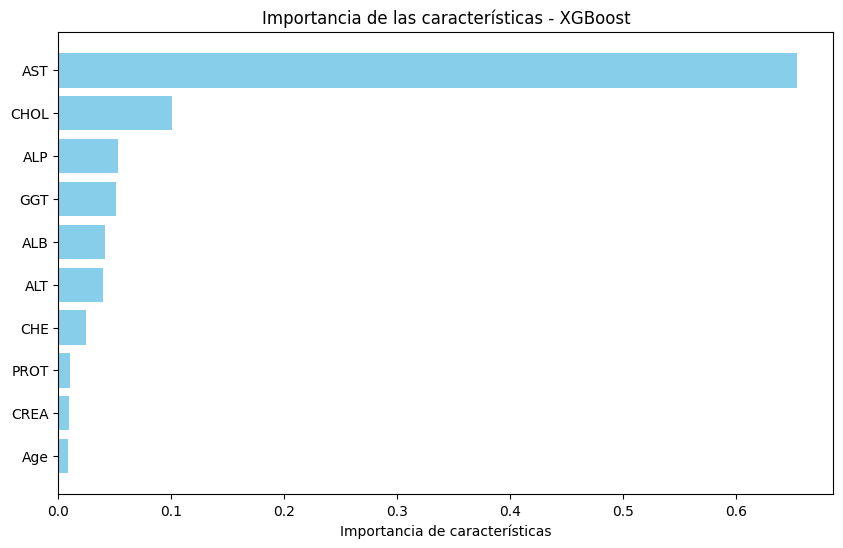

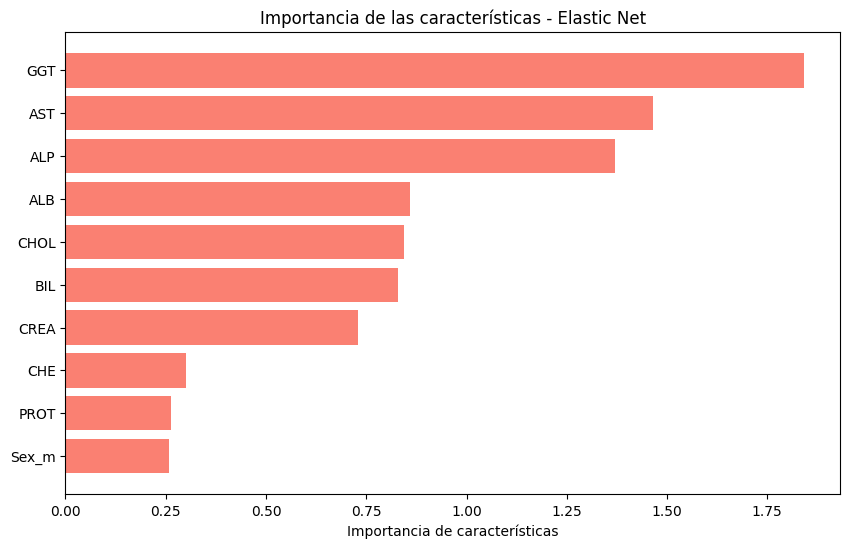

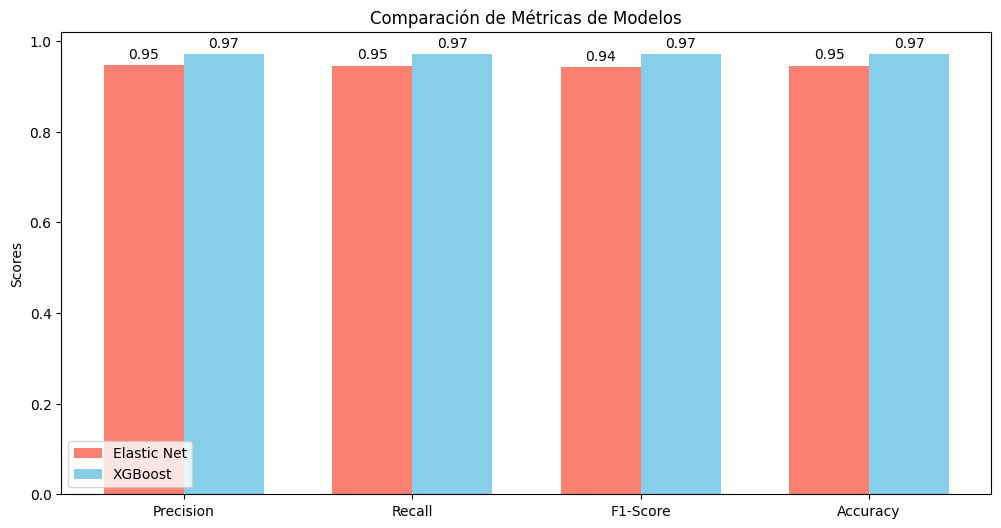

In [17]:
import matplotlib.pyplot as plt

# Importancia de los atributos para XGBoost
xgb_importances = grid_search.best_estimator_.feature_importances_
sorted_idx_xgb = np.argsort(xgb_importances)[::-1]
xgb_features = [features.columns[i] for i in sorted_idx_xgb]

plt.figure(figsize=(10, 6))
plt.barh(xgb_features[:10], xgb_importances[sorted_idx_xgb[:10]], color="skyblue")
plt.xlabel("Importancia de características")
plt.title("Importancia de las características - XGBoost")
plt.gca().invert_yaxis()
plt.show()

# Importancia de los atributos para Elastic Net
logreg_importances = np.abs(logreg_cv.coef_[0])
sorted_idx_logreg = np.argsort(logreg_importances)[::-1]
logreg_features = [features.columns[i] for i in sorted_idx_logreg]

plt.figure(figsize=(10, 6))
plt.barh(
    logreg_features[:10], logreg_importances[sorted_idx_logreg[:10]], color="salmon"
)
plt.xlabel("Importancia de características")
plt.title("Importancia de las características - Elastic Net")
plt.gca().invert_yaxis()
plt.show()

# Comparación de Métricas
metrics = ["Precision", "Recall", "F1-Score", "Accuracy"]
elastic_net_scores = [precision, recall, f1, accuracy]
xgb_scores = [precision_xgb, recall_xgb, f1_xgb, accuracy_xgb]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(
    x - width / 2, elastic_net_scores, width, label="Elastic Net", color="salmon"
)
rects2 = ax.bar(x + width / 2, xgb_scores, width, label="XGBoost", color="skyblue")

ax.set_ylabel("Scores")
ax.set_title("Comparación de Métricas de Modelos")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.2f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

plt.show()

```  
Podemos ver como XGBOOST es mejor modelo 